In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("dark")

!pip install pydicom
import pydicom

import matplotlib.pyplot as plt
from google.colab import drive, files
from os.path import join  
import os, csv, random, PIL
from zipfile import ZipFile
from PIL import Image, ImageEnhance

from skimage import io, measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

!pip install wandb 
import wandb
from wandb.keras import WandbCallback

!pip install visualkeras

     |████████████████████████████████| 1.9MB 4.0MB/s 
     |████████████████████████████████| 1.8MB 3.8MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 143kB 12.4MB/s 
     |████████████████████████████████| 174kB 12.4MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=2ee744d7d346d2073efb3b561fb1c1f802bf97d3b14d60bfb653adcb9bf0b57f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=ef3a57c39b29b258581103a7a5ecaf02542b02e60c56fe1d3a728c359f6b3921
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


     |████████████████████████████████| 798kB 2.9MB/s 


In [ ]:
# # path to your project on Google Drive
train_folder = 'stage_2_train_images/'
saved_folder = 'Saved_Data/'

PROJECT_PATH = '/content/'
TRAIN_PATH = join(PROJECT_PATH, train_folder)
SAVE_PATH = join(PROJECT_PATH, saved_folder)

if not os.path.exists(SAVE_PATH): os.makedirs(SAVE_PATH)

## Kaggle Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-pneumonia-detection-challenge

     |████████████████████████████████| 61kB 2.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=023f099df17910d75f1be717b171c240042fd85e4f9a61ca5c50b7c54e2b518d
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
100% 3.66G/3.66G [00:32<00:00, 135MB/s]
100% 3.66G/3.66G [00:32<00:00, 122MB/s]


In [ ]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
datafile = ZipFile(file_name, 'r')
datafile.extractall()

## Read the data from the folders

In [ ]:
data_folder = '/content/'

train_labels = pd.read_csv(data_folder + 'stage_2_train_labels.csv')
class_info = pd.read_csv(data_folder +'stage_2_detailed_class_info.csv')

print(f'Train Labels has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Train Labels # of patientID duplicates: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Class Info # of patientID duplicates: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Train Labels has 30227 rows and 6 columns
Class info has 30227 rows and 2 columns
Train Labels # of patientID duplicates: 3543
Class Info # of patientID duplicates: 3543


In [ ]:
class_info_train_labels_merge = train_labels.merge(class_info, left_on='patientId', right_on='patientId', how='inner')
class_info_train_labels_merge.head()

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 7 columns]

## Read the DICOM Images from the folders

In [ ]:
# Function to load an image
def load_image(imagename):
  image1 = pydicom.dcmread(imagename)
  print(type(image1))
  return image1

<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>


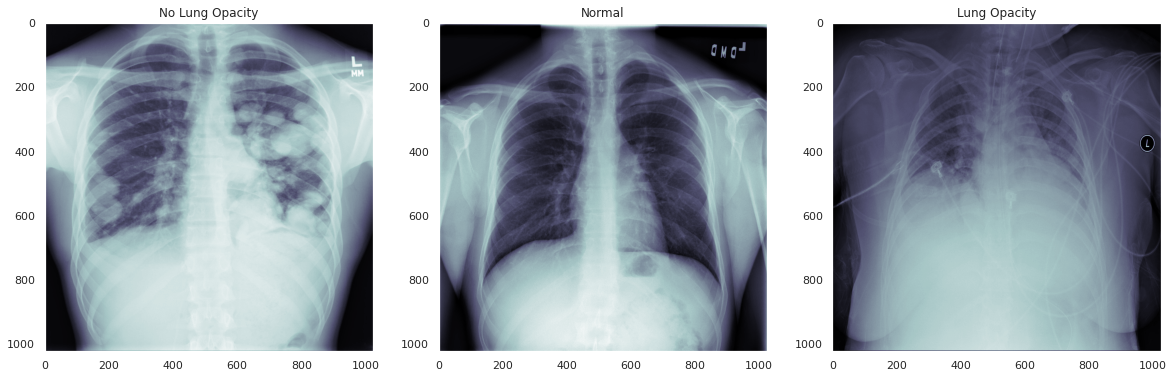

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3 ,figsize=(20,15))
axes[0].set_title('No Lung Opacity')
axes[0].imshow(load_image('/content/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm').pixel_array, cmap=plt.cm.bone)
axes[1].set_title('Normal')
axes[1].imshow(load_image('/content/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm').pixel_array, cmap=plt.cm.bone)
axes[2].set_title('Lung Opacity')
axes[2].imshow(load_image('/content/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm').pixel_array, cmap=plt.cm.bone)

## Analyze the metadata associated with the images

In [ ]:
#Check data within a sample file
dcm_data = pydicom.read_file('/content/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm')
print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.11252.1517874357.450548
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.11252.1517874357.450548
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Function to fetch dicom data from files
# We need to create a combined file with all the parameters in one place.
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def get_DICOM_metadata(class_info): 
  if(os.path.isfile(PROJECT_PATH+'Data/class_info_train_labels_merge_metadata.csv')):
    class_info = pd.read_csv(PROJECT_PATH+'Data/class_info_train_labels_merge_metadata.csv')
    class_info.drop([class_info.columns[0]], axis=1, inplace=True)
  else:
    #get file list from folder
    image_train_path = os.listdir(PROJECT_PATH+'stage_2_train_images')
    image_test_path = os.listdir(PROJECT_PATH+'stage_2_test_images')
    print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

    vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

    for var in vars:
          class_info[var] = None
    #iterate on files and append metadata
    for i,filename in enumerate(image_train_path):
      #print('processing:',i,filename)
      dcm_data = pydicom.read_file(PROJECT_PATH+'stage_2_train_images/'+filename)
      idx = (class_info['patientId']==dcm_data.PatientID)
      class_info.loc[idx,'Modality'] = dcm_data.Modality
      class_info.loc[idx,'PatientAge'] = pd.to_numeric(dcm_data.PatientAge)
      class_info.loc[idx,'PatientSex'] = dcm_data.PatientSex
      class_info.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
      class_info.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
      class_info.loc[idx,'ConversionType'] = dcm_data.ConversionType
      class_info.loc[idx,'Rows'] = dcm_data.Rows
      class_info.loc[idx,'Columns'] = dcm_data.Columns  
      class_info.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",dcm_data.PixelSpacing[0]) 
    #save to a file for future and dont run the function if the file exists
    class_info.to_csv(PROJECT_PATH+'class_info_train_labels_merge_metadata.csv')
  
  class_info['xc'] = class_info['x'] + class_info['width'] / 2
  class_info['yc'] = class_info['y'] + class_info['height'] / 2

  return class_info

class_info_train_labels_merge_metadata = get_DICOM_metadata(class_info_train_labels_merge)

class_info_train_labels_merge_metadata.head()

Number of images in train set: 26684 
Number of images in test set: 3000


patientId      x  ...     xc     yc
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...    NaN    NaN
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...    NaN    NaN
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...    NaN    NaN
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...    NaN    NaN
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...  370.5  341.5

[5 rows x 18 columns]

Functions to show images with bounding boxes where they exist

In [ ]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PROJECT_PATH,"stage_2_train_images/",patientImage)
        #print(imagePath)
        data_row_img_data = pydicom.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = load_image(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = class_info_train_labels_merge_metadata[class_info_train_labels_merge_metadata['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="blue",alpha = 0.1))   
    plt.show()

<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>


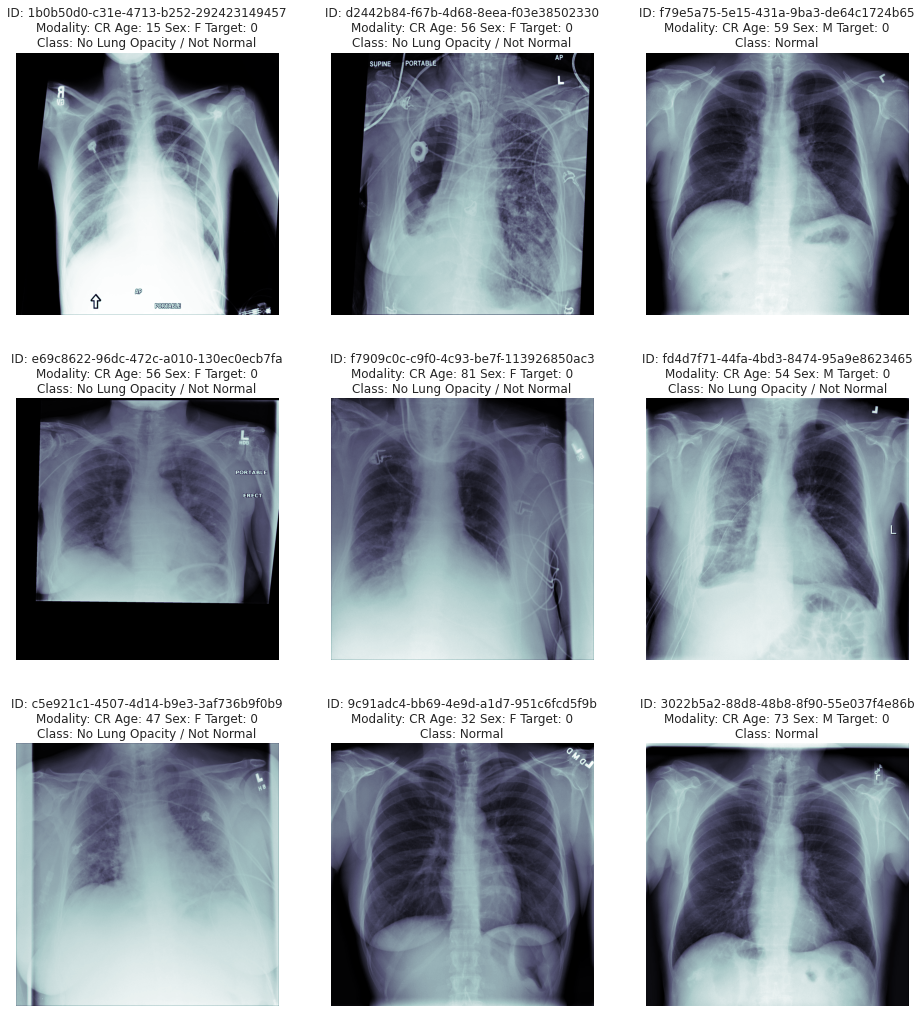

In [ ]:
show_dicom_images_with_boxes(class_info_train_labels_merge_metadata[class_info_train_labels_merge_metadata['Target']==0].sample(9))

<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>
<class 'pydicom.dataset.FileDataset'>


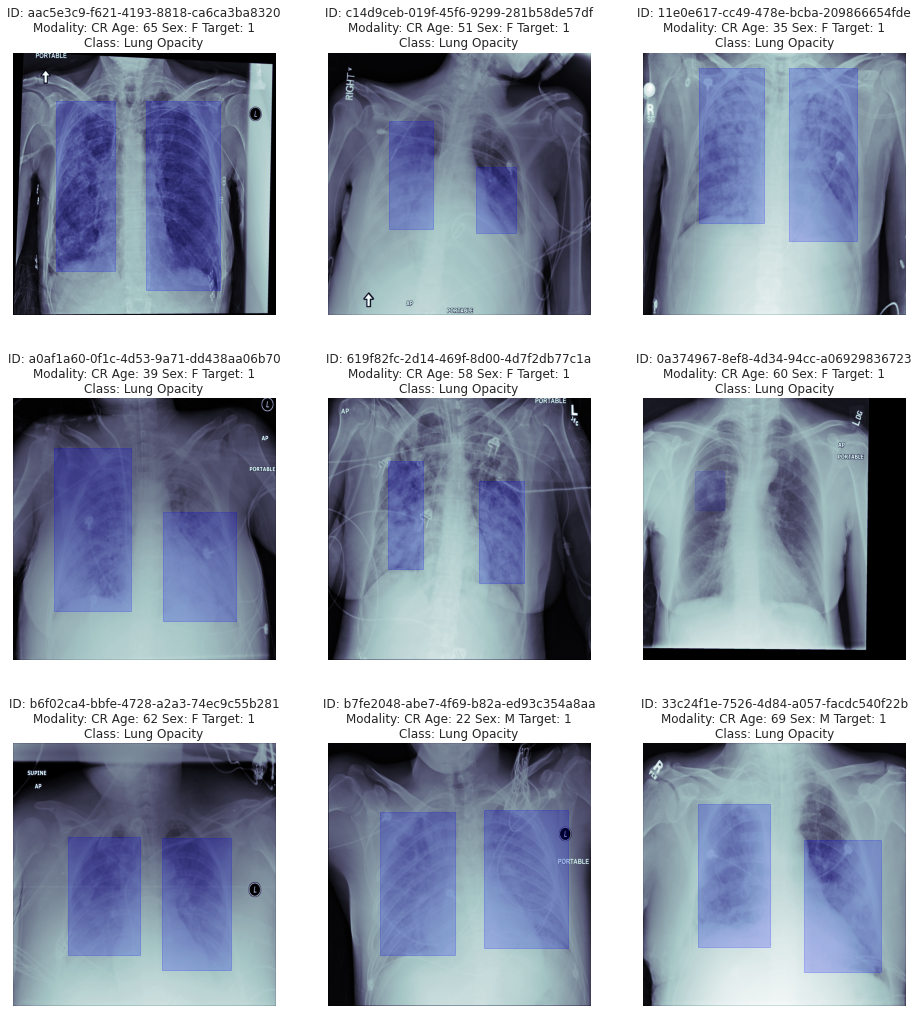

In [ ]:
show_dicom_images_with_boxes(class_info_train_labels_merge_metadata[class_info_train_labels_merge_metadata['Target']==1].sample(9))

## Split into train and validation data sets as preparation for training

In [ ]:
print(TRAIN_PATH)
filenames = {}

read_directory = True
if(read_directory):
  filenames = os.listdir(TRAIN_PATH)
  pd.DataFrame(filenames).to_csv(SAVE_PATH+'train_path_listdir.csv')
else:
  filenames=pd.read_csv(SAVE_PATH+'train_path_listdir.csv', usecols=[1],header=0).values.tolist()
  filenames = [val for sublist in filenames for val in sublist]

# Use part of the data for training earlier and then run for 100% of the data
percentage_data_used = 100
file_count = int(len(filenames)*percentage_data_used/100)
print("Total files available:",file_count)

random.shuffle(filenames)

# split into train and validation filenames
n_valid_samples = int(file_count * 0.3)

train_filenames = filenames[n_valid_samples:file_count]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

image_dimension = 256
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[0])

/content/stage_2_train_images/
Total files available: 26684
n train samples 18679
n valid samples 8005
Image Dimension to use: 256
sample file: acf2dc69-0b5e-4600-a2c4-887c5d37438b.dcm


## Check distribution of train and test vs original

In [ ]:
# Check dist of selected files based on the csv that was provided. 
# Did not try stratified sampling since the distribution is not impacted much.
def check_distribution(dataframe_to_check):
  filename_check = pd.DataFrame(columns=['patientId','class'])
  #get filename 
  for filename in dataframe_to_check:
    filename_check = filename_check.append(class_info[class_info['patientId'] == filename.split('.')[0]])
    
  print('Rows',len(filename_check))
  print('unique',len(filename_check['patientId'].unique()))
  print(filename_check['class'].value_counts(normalize = True))

check_distribution(train_filenames)
check_distribution(valid_filenames)

Rows 21150
unique 18679
No Lung Opacity / Not Normal    0.390733
Lung Opacity                    0.317021
Normal                          0.292246
Name: class, dtype: float64
Rows 9077
unique 8005
No Lung Opacity / Not Normal    0.39187
Lung Opacity                    0.31398
Normal                          0.29415
Name: class, dtype: float64


In [ ]:
check_distribution(filenames)
# Overall Distribution is very similar to the distribution in train and validation data set.

Rows 30227
unique 26684
No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64


In [ ]:
# identifying if there are any files beside dcm in the folder
for name in filenames:
  le = len(name)
  if(name[le-3:le] != 'dcm'):
    print(name)

## Create a dictionary of pneumonia locations in one place.

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PROJECT_PATH,'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

## Define the Image Generator class

In [ ]:

# The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.
# Generator class to handle:
# Image load from folder during train and predict modes, shuffle on epoc end, 
# resize loaded images, augment if needed, add trailing channel dimension
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=100, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    # Loads the file from folder, resizes and augments the data with horizontal flip    
    def __load__(self, filename):
        # load dicom file as numpy array
        #print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array

        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.7:
            img = np.fliplr(img)
            msk = np.fliplr(msk)

            PIL_image = Image.fromarray(np.uint8(img)) #.convert('RGB')
            PIL_mask = Image.fromarray(np.uint8(msk)) #.convert('RGB')

            angle = random.randint(-5,5)
            PIL_image = PIL.Image.Image.rotate(PIL_image, angle, resample=0, expand=0)
            PIL_mask = PIL.Image.Image.rotate(PIL_mask, angle, resample=0, expand=0)

            blur_radius = random.randint(0,2)
            PIL_image = PIL_image.filter(PIL.ImageFilter.GaussianBlur(radius=blur_radius))
            PIL_mask = PIL_mask.filter(PIL.ImageFilter.GaussianBlur(radius=blur_radius))

            sharpness_factor = 2
            PIL_image = ImageEnhance.Sharpness(PIL_image).enhance(sharpness_factor)

            img = np.array(PIL_image) 
            msk = np.array(PIL_mask)

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    # Loads images during prediction cycles
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        # print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    # Generator must implement this getter function    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            
            msks = np.array(msks)
            return imgs, msks

    # Shuffle data before start of next epoc    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Construct the network backbone by stacking up various layers

In [ ]:
LR = 0.01
EPOCHS = 15
BATCHSIZE = 64
CHANNELS = 32
IMAGE_SIZE = 256
NBLOCK = 6 
DEPTH = 4
MOMENTUM = 0.9

In [ ]:
# Network

def convlayer(channels, inputs, size=3, padding='same'):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, size, padding=padding, use_bias=False)(x)
    return x

def just_downsample(inputs, pool=2):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(pool)(x)
    return x

def convblock(inputs, channels1, channels2):
    x = convlayer(channels1, inputs)
    x = convlayer(channels2, x)
    x = keras.layers.Concatenate()([inputs, x])
    return x

def denseblock(inputs, nblocks=6, channels1=128, channels2=32):
    x = inputs
    for i in range(nblocks):
        x = convblock(x, channels1, channels2)
    x = keras.layers.SpatialDropout2D(.2)(x)
    return x

def transition(inputs, channels, pool=2):
    x = convlayer(channels, inputs)
    x = keras.layers.AveragePooling2D(pool)(x)
    return x
    
def create_network(input_size, channels=64, channels2=32, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=2, use_bias=False)(inputs)
    x = just_downsample(x)

    # densenet blocks
    nchan = channels
    for d in range(depth-1):
        x = denseblock(x)
        nchan = ( nchan + n_blocks*channels2 ) // 2
        x = transition(x, nchan)
    x = denseblock(x)

    # output
    x = convlayer(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    #x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.LeakyReLU(0)(x)
    #x = keras.layers.Dropout(.5)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)

    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.UpSampling2D(4)(x)
    output = keras.layers.UpSampling2D(4)(x)


    model = keras.Model(inputs=inputs, outputs=output)
    return model

## Define the IOU metrics to be used for tracking, compile and view the model

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true,dtype='float32')
    y_pred = tf.cast(y_pred,dtype='float32')
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) +  0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

#create network and compiler
#model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=4)
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)


model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

model.summary()

# cosine learning rate annealing
# changes learning rate based on the number of epocs passed
def cosine_annealing(x):
    lr = LR
    return lr* (np.cos(np.pi*x/EPOCHS)+1.) /2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# keeps logging the epoc output simultaneously while training
csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs.csv', append = True)

# Creating checkpoint of the best model to avoid save errors later on.
# Saves training time once the best model is achieved.
cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

# Keep monitoring val_loss to see if there is any improvement. 
# Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
# Any improvement of 0.5% in val_loss would get captured
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Let us visualize the model

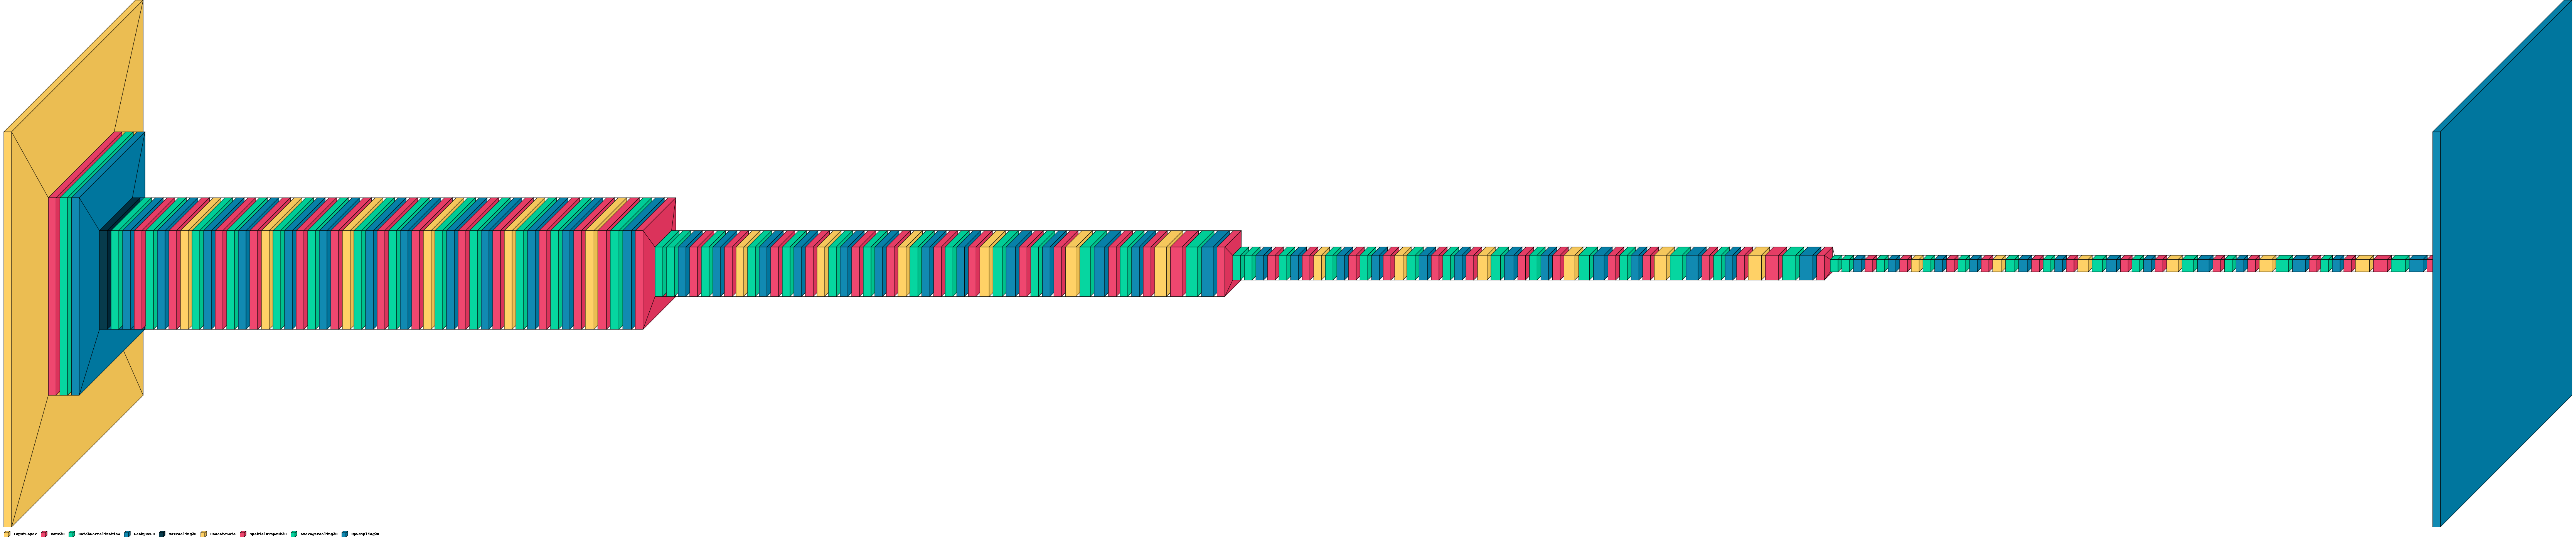

In [ ]:
import visualkeras 
visualkeras.layered_view(model,legend=True)

Initialize the Weights and Biases for visualization

In [ ]:
hyperparameter_defaults = dict(
    wandblr=[0.001,0.002,0.005],
    epochs=5,
    )

wandb.init(config=hyperparameter_defaults)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Train the model and observe the performance

In [ ]:
# create train and validation generators
train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=BATCHSIZE, image_size=image_dimension, shuffle=True, augment=False, predict=False)
valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=BATCHSIZE, image_size=image_dimension, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,csv_logger,early_stopping, WandbCallback()], epochs=EPOCHS, workers=4, use_multiprocessing=True)

# Save Model and history
training_mode = True
if(training_mode):
  export_file_path = SAVE_PATH+'pneumonia_model.h5'

  # Save the model
  model.save(export_file_path)
  print('model saved')

  # Save history file
  print(history.history.keys())
  # convert the history.history dict to a pandas DataFrame:     
  hist_df = pd.DataFrame(history.history) 

  # or save to csv: 
  hist_csv_file = SAVE_PATH+'pneumonia_model_history.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)
  print('history saved')

  
else:
  model.load_weights(SAVE_PATH+'pneumonia_model.h5')
  history = pd.read_csv(SAVE_PATH+'pneumonia_model_history.csv')
  history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
291/291 [==============================] - 1792s 6s/step - loss: 0.5062 - accuracy: 0.9583 - mean_iou: 0.6646 - val_loss: 0.4780 - val_accuracy: 0.9609 - val_mean_iou: 0.6593
Epoch 2/15
291/291 [==============================] - 1777s 6s/step - loss: 0.4676 - accuracy: 0.9636 - mean_iou: 0.6885 - val_loss: 0.4654 - val_accuracy: 0.9568 - val_mean_iou: 0.6914
Epoch 3/15
291/291 [==============================] - 1786s 6s/step - loss: 0.4581 - accuracy: 0.9649 - mean_iou: 0.7038 - val_loss: 0.5152 - val_accuracy: 0.9669 - val_mean_iou: 0.6307
Epoch 4/15
291/291 [==============================] - 1778s 6s/step - loss: 0.4505 - accuracy: 0.9661 - mean_iou: 0.7128 - val_loss: 0.4676 - val_accuracy: 0.9474 - val_mean_iou: 0.6647
Epoch 5/15
291/291 [==============================] - 1785s 6s/step - loss: 0.4457 - accuracy: 0.9664 - mean_iou: 0.7160 - val_loss: 0.4422 - val_accuracy: 0.9649 - val_mean_iou: 0.7255
Epoch 6/15
291/291 [==============================] - 1783s 6s/step - 

## View the model performance

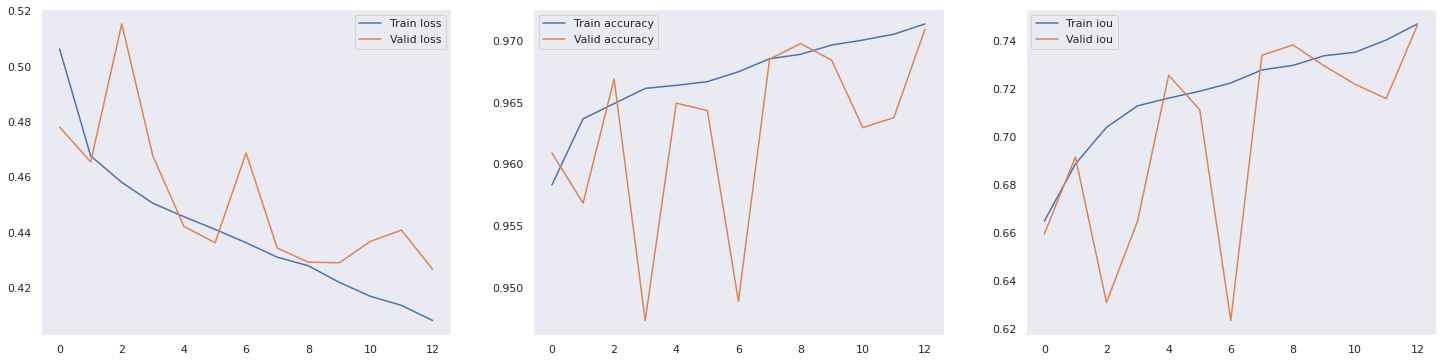

In [ ]:
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Let us predict the bounding boxes for some images in the validation set

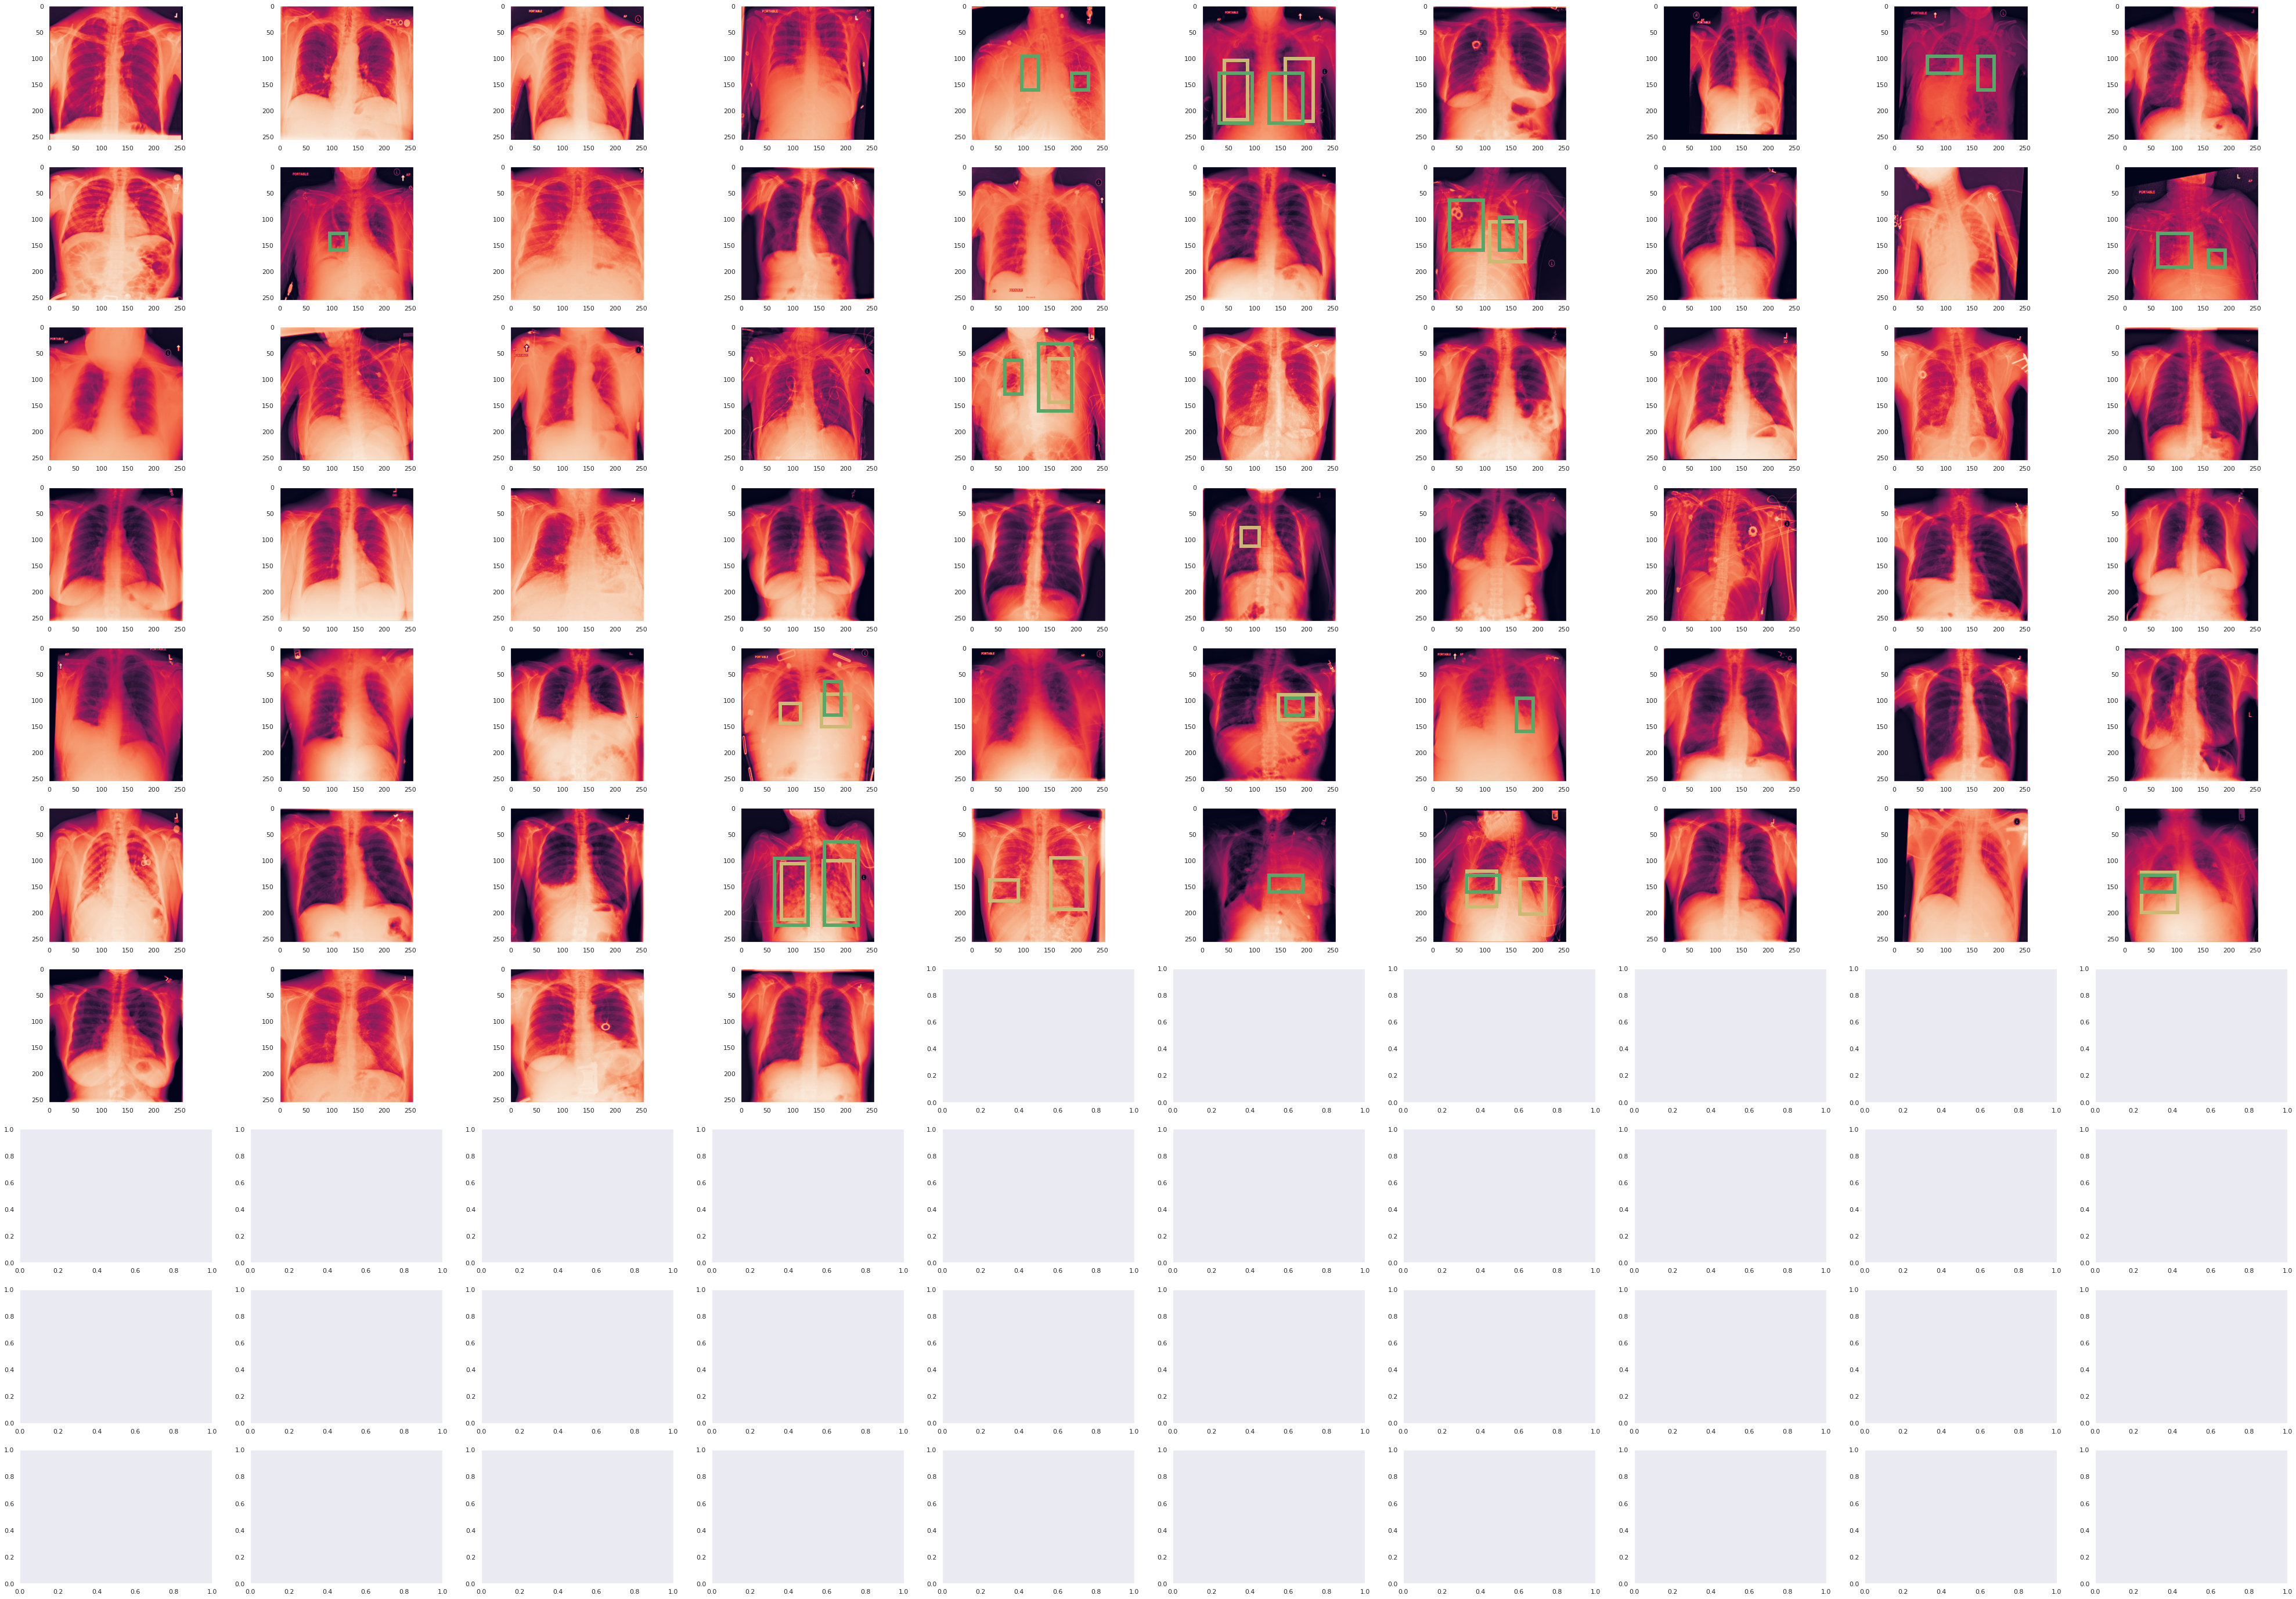

In [ ]:
# Green is predicted mask, Yellow is actual Mask
for imgs, msks in valid_gen:
    
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(10, 10, figsize=(70,50))

    # Flatten the array
    axarr = axarr.ravel()
    axidx = 1

    #print("$%$",len(msks))

    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        #print(axidx,":",axarr[axidx])
        axarr[axidx-1].imshow(img[:, :, 0])


        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx-1].add_patch(patches.Rectangle((x,y),width,height,linewidth=6,edgecolor='y',facecolor='none'))
        
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx-1].add_patch(patches.Rectangle((x,y),width,height,linewidth=6,edgecolor='g',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

    # There was considerable IOU for the images where prediction was correct. 